In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  
import json
import os
from datetime import datetime
# import plotly.graph_objects as go
# from Custom_tools.plotting_utils import plot_ohlc_with_sr

In [2]:
filename = input("Enter filename in capital letters: ") 
timeframe = 1

#### Data Wrangling

In [3]:
# ["ADANIPORTS","AXISBANK","HDFCBANK", "HINDALCO","ICICIBANK", "INFY", "M&M", "RELIANCE", "POWERGRID", "SBIN"]

In [4]:
# df = pd.read_csv(f"../Data/1_minute_data/{filename}").set_index("datetime")
# df.index = pd.to_datetime(df.index)

In [5]:
df = pd.read_parquet(
    f"s3://quant-ohlcv-data/ohlcv/timeframe={timeframe}min/symbol={filename}/"
)
if "datetime" in df.columns:
    df = df.set_index("datetime")

In [6]:
# start_date = pd.Timestamp("2023-02-01", tz="Asia/Kolkata")
# end_date   = pd.Timestamp("2025-12-31", tz="Asia/Kolkata")

# df = df.loc[start_date:end_date]

In [7]:
df.head()

,open,high,low,close,volume
datetime,,,,,
2018-01-01 09:16:00+05:30,406.70,407.00,403.70,404.25,15018
2018-01-01 09:17:00+05:30,404.55,404.90,403.30,404.50,12209
2018-01-01 09:18:00+05:30,404.55,406.30,404.55,405.50,7837
2018-01-01 09:19:00+05:30,405.55,405.65,404.60,404.70,3614
2018-01-01 09:20:00+05:30,405.10,405.10,404.20,404.55,4542


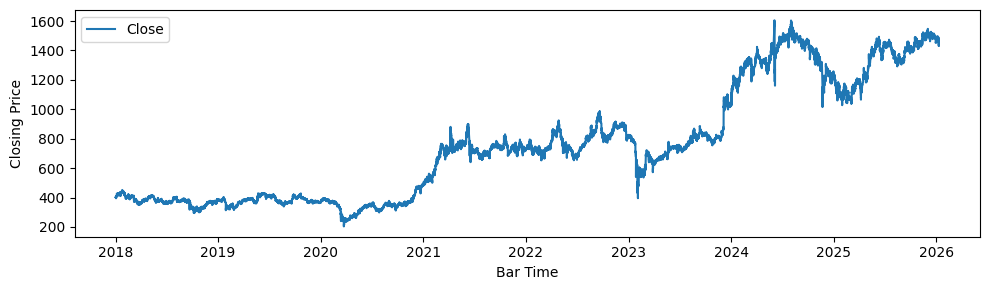

In [8]:
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(df["close"], label="Close")

ax.set_xlabel("Bar Time")
ax.set_ylabel("Closing Price")

plt.legend()
plt.tight_layout()
plt.show()


In [9]:
df["resistance"] = df["close"].shift().rolling(10).max()
df["support"]    = df["close"].shift().rolling(10).min()

df= df.dropna(how="any")


In [10]:
df[["close","support","resistance"]].head()

,close,support,resistance
datetime,,,
2018-01-01 09:26:00+05:30,405.20,404.25,405.5
2018-01-01 09:27:00+05:30,405.15,404.30,405.5
2018-01-01 09:28:00+05:30,405.00,404.30,405.5
2018-01-01 09:29:00+05:30,404.60,404.30,405.2
2018-01-01 09:30:00+05:30,404.35,404.30,405.2


In [11]:
# plot_ohlc_with_sr(df.tail(75))

In [12]:
df[["close", "high", "low", "support", "resistance"]].head()

,close,high,low,support,resistance
datetime,,,,,
2018-01-01 09:26:00+05:30,405.20,405.35,404.80,404.25,405.5
2018-01-01 09:27:00+05:30,405.15,405.30,405.15,404.30,405.5
2018-01-01 09:28:00+05:30,405.00,405.15,404.95,404.30,405.5
2018-01-01 09:29:00+05:30,404.60,405.00,404.40,404.30,405.2
2018-01-01 09:30:00+05:30,404.35,404.65,404.35,404.30,405.2


    ATR implementation for stop loss

In [13]:
# Calculate True Range (Wilder's definition)
df['prev_close'] = df['close'].shift(1)
df['tr'] = df[['high', 'low', 'prev_close']].apply(
    lambda x: max(x['high'] - x['low'], 
                      abs(x['high'] - x['prev_close']), 
                                        abs(x['low'] - x['prev_close'])), axis=1
                                        )
df['atr'] = df['tr'].shift().rolling(14).mean()

#### Indicators as filter

In [14]:
# Calculate RSI (14-period standard)
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI
df['rsi'] = calculate_rsi(df['close'], period=14).shift()  # shift to avoid lookahead


#### Creating Strategy

    Adding a trend filter.

In [15]:
# Add simple trend filter
df['sma_50'] = df['close'].shift().rolling(50).mean()
df['sma_200'] = df['close'].shift().rolling(200).mean()
df["sma_20"] = df["close"].shift().rolling(20).mean() 

# Uptrend: price > SMA50 > SMA200
df['uptrend'] = (
                 (df["close"]>df["sma_20"])
                 ).astype(int)

df["downtrend"] = (
                 (df["close"]<df["sma_20"])
                 ).astype(int)


    Calculating Entry Signal 

In [ ]:
df['entry_signal'] = (
    (df['low'] <= df['support'])
    & (df['uptrend'] == 1)
).astype(int)


TypeError: 'Series' object is not callable

    Calculating Entry Price

In [ ]:
df["entry_price"] = np.where(df["entry_signal"]==1, df["support"], np.nan)

    Calculating Exit conditions

In [ ]:
df["target_price"] = np.where(df["entry_signal"]==1, df["resistance"], np.nan )

df["stop_loss_price"] = np.where(df["entry_signal"]==1, df["entry_price"]-(1 * df["atr"]), np.nan)

#### Creating positions

    Initializing variables

#### Creating Long Positions

In [ ]:
#INitializing trade pnl logic
df["trade_pnl"] = 0.0
df["exit_reason"] = ''
df["in_position"] = 0
trade_pnls = []
starting_capital = df.iloc[0]['close']
# starting_capital = 10000


entry_price = np.nan
stop_price = np.nan
target_price = np.nan
in_trade = False
TRANSACTION_COST = 0.0002

#For machine Learning
entry_index = None
df["ml_target"] =  np.nan
df["holding_period"] = np.nan

In [ ]:
for i in range(len(df)):
    idx = df.index[i]

    #Mark if we are in position in this bar

    df.loc[idx, "in_position"] = 1 if  in_trade else 0


    #Exit logic first

    if in_trade:
        current_low = df.loc[idx, "low"]
        current_high = df.loc[idx, "high"]

        #Exit conditions
        if current_low<= stop_price:
            exit_price = stop_price
            exit_reason = "STOP" 
        elif current_high >= target_price:
            exit_price = target_price
            exit_reason = "TARGET"
        else:
            exit_price = None
        #Calculating PNL
        if exit_price is not None:
            pnl_per_share_gross = exit_price - entry_price
            
            #Calculating transaction cost
            cost_entry_per_share = entry_price * TRANSACTION_COST
            cost_exit_per_share = exit_price * TRANSACTION_COST
            total_cost_per_share = cost_entry_per_share + cost_exit_per_share

            pnl_per_share_net = pnl_per_share_gross - total_cost_per_share

            #Calculate position size
            # position_value = starting_capital
            # shares = position_value/entry_price
            shares = 1

            #Total pnl for the position
            pnl_total_gross = pnl_per_share_gross * shares
            total_cost_total = total_cost_per_share * shares
            pnl_total_net = pnl_per_share_net * shares

            trade_pnls.append(pnl_total_net)

            # Assign to dataframe at exit bar

            df.loc[idx, 'trade_pnl'] =  pnl_total_net
            df.loc[idx, 'exit_reason'] = exit_reason
            # Use percentage return (comparable across stocks):
            df.loc[entry_index, 'ml_target'] = (pnl_per_share_net / entry_price) * 100
            df.loc[entry_index, "holding_period"] = i - df.index.get_loc(entry_index)


            #Reset state

            in_trade = False
            entry_price = np.nan
            stop_price = np.nan
            target_price = np.nan
    
    #Entry logic
    elif df.loc[idx, "entry_signal"] == 1:
        in_trade = True
        entry_price = df.loc[idx, "entry_price"]
        stop_price = df.loc[idx, "stop_loss_price"]
        target_price = df.loc[idx, "target_price"]

        entry_index = idx

 

In [ ]:
np.sum(trade_pnls)

np.float64(485.4249790000024)

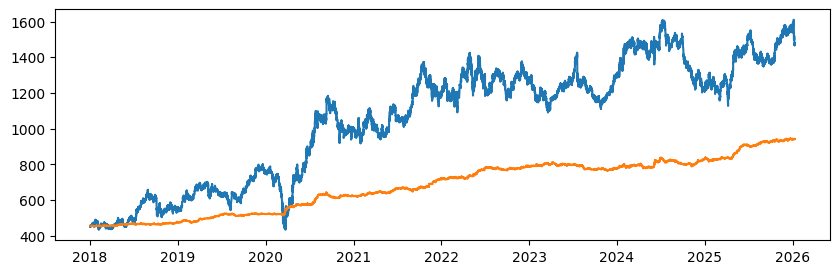

In [ ]:
df["cumulative_pnl"] = df["trade_pnl"].cumsum()
df["equity_curve"] = starting_capital + df["cumulative_pnl"]

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df["close"])
ax.plot(df["equity_curve"])

In [ ]:
df['ml_target'].values

array([nan, nan, nan, ..., nan, nan, nan], shape=(742738,))

In [ ]:
df['ml_target'].notna().sum()

np.int64(5140)

In [ ]:
df['ml_target'].isna().sum()

np.int64(737598)

In [ ]:
# Add this right after your loop
print(f"\nTotal trades executed: {len(trade_pnls)}")
print(f"ML targets stored: {df['ml_target'].notna().sum()}")
print(f"Entry signals: {(df['entry_signal'] == 1).sum()}")


Total trades executed: 5140
ML targets stored: 5140
Entry signals: 6532


#### Adding shorting opportunities

In [ ]:
df['entry_signal_short'] = (
    (df['high'] >= df['resistance'])
    & (df['downtrend'] == 1)
).astype(int)

In [ ]:
# Entry at close when price touches resistance
df["entry_price_short"] = np.where(df["entry_signal_short"]==1, 
                                    df["resistance"], 
                                    np.nan)

In [ ]:

df["target_price_short"] = np.where(df["entry_signal_short"]==1, 
                                    df["support"],  # or df["close"] - (2 * df["atr"])
                                    np.nan)

# Stop ABOVE entry (correct - you have this right!)
df["stop_loss_price_short"] = np.where(df["entry_signal_short"]==1, 
                                       df["entry_price_short"] + (1 * df["atr"]), 
                                       np.nan)

In [ ]:
# Initializing trade pnl logic for SHORTS
df["trade_pnl_short"] = 0.0
df["exit_reason_short"] = ''
df["in_position_short"] = 0
trade_pnls_short = []
starting_capital_short = df.iloc[0]['close']
# starting_capital_short = 10000

entry_price_short = np.nan
stop_price_short = np.nan
target_price_short = np.nan
in_trade_short = False
TRANSACTION_COST_SHORT = 0.0002  # Consider if shorts have higher costs

# For machine learning
entry_index_short = None
df["ml_target_short"] = np.nan
df["holding_period_short"] = np.nan

In [ ]:
for i in range(len(df)):
    idx = df.index[i]

    # Mark if we are in position in this bar
    df.loc[idx, "in_position_short"] = 1 if in_trade_short else 0

    # Exit logic first
    if in_trade_short:
        current_low = df.loc[idx, "low"]
        current_high = df.loc[idx, "high"]

        # Exit conditions (INVERTED for shorts)
        if current_high >= stop_price_short:  # Stop hit when price goes UP
            exit_price = stop_price_short
            exit_reason = "STOP" 
        elif current_low <= target_price_short:  # Target hit when price goes DOWN
            exit_price = target_price_short
            exit_reason = "TARGET"
        else:
            exit_price = None
            
        # Calculating PNL
        if exit_price is not None:
            # INVERTED: profit when exit < entry for shorts
            pnl_per_share_gross = entry_price_short - exit_price  
            
            # Calculating transaction cost
            cost_entry_per_share = entry_price_short * TRANSACTION_COST_SHORT
            cost_exit_per_share = exit_price * TRANSACTION_COST_SHORT
            total_cost_per_share = cost_entry_per_share + cost_exit_per_share

            pnl_per_share_net = pnl_per_share_gross - total_cost_per_share

            # Calculate position size
            # position_value = starting_capital_short
            # shares = position_value / entry_price_short
            shares = 1

            # Total pnl for the position
            pnl_total_gross = pnl_per_share_gross * shares
            total_cost_total = total_cost_per_share * shares
            pnl_total_net = pnl_per_share_net * shares

            trade_pnls_short.append(pnl_total_net)

            # Assign to dataframe at exit bar
            df.loc[idx, 'trade_pnl_short'] = pnl_total_net
            df.loc[idx, 'exit_reason_short'] = exit_reason
            
            # Use percentage return (comparable across stocks):
            df.loc[entry_index_short, 'ml_target_short'] = (pnl_per_share_net / entry_price_short) * 100
            df.loc[entry_index_short, "holding_period_short"] = i - df.index.get_loc(entry_index_short)

            # Reset state
            in_trade_short = False
            entry_price_short = np.nan
            stop_price_short = np.nan
            target_price_short = np.nan
    
    # Entry logic
    elif (df.loc[idx, "entry_signal_short"] == 1) and (not in_trade_short):

        in_trade_short = True
        entry_price_short = df.loc[idx, "entry_price_short"]
        stop_price_short = df.loc[idx, "stop_loss_price_short"]
        target_price_short = df.loc[idx, "target_price_short"]
        
        entry_index_short = idx

In [ ]:
df["ml_target_short"].notna().sum()

np.int64(3108)

In [ ]:
df["ml_target_short"].isna().sum()

np.int64(739630)

In [ ]:
np.sum(trade_pnls_short)

np.float64(829.6894952857178)

In [ ]:
df["trade_pnl_total"] = df["trade_pnl"] + df["trade_pnl_short"]


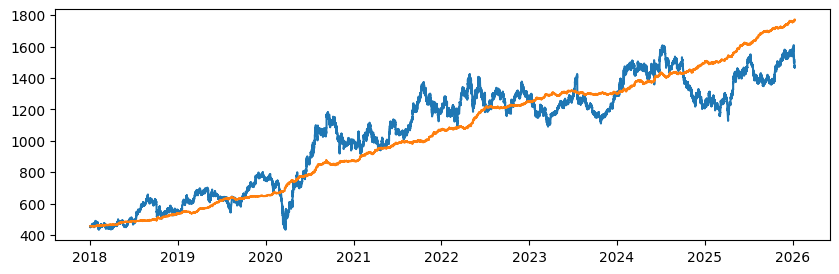

In [ ]:
df["cumulative_pnl"] = df["trade_pnl_total"].cumsum()
df["equity_curve"] = starting_capital + df["cumulative_pnl"]

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df["close"])
ax.plot(df["equity_curve"])

#### Year On Year Results

C:\Users\LuvRatan\AppData\Local\Temp\ipykernel_28432\3620161310.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_df = df.groupby('year').apply(calculate_year_metrics).reset_index()


YEAR-ON-YEAR PERFORMANCE
 year  Start Equity  End Equity  Total Return (%)  Max Drawdown (%)  Trades  Win Rate (%)  Avg Win  Avg Loss  Sharpe Ratio
 2018    456.000000  537.359462         17.841987         -1.927491  1019.0     60.058881 0.520143 -0.582231      0.187497
 2019    537.359462  647.972276         20.584510         -2.743442   950.0     60.842105 0.645180 -0.705111      0.237500
 2020    647.972276  873.415074         34.792044         -3.662657   805.0     62.732919 1.265979 -1.379588      0.262018
 2021    873.415074 1067.528735         22.224675         -1.920842   896.0     61.941964 1.173932 -1.341404      0.221071
 2022   1067.528735 1251.456197         17.229275         -1.442188   928.0     62.392241 1.171466 -1.416480      0.208935
 2023   1251.456197 1301.035591          3.961736         -2.266627  1205.0     59.502075 0.753202 -1.005055      0.072199
 2024   1301.035591 1499.932745         15.287603         -2.420056  1162.0     63.769363 1.131731 -1.519514      

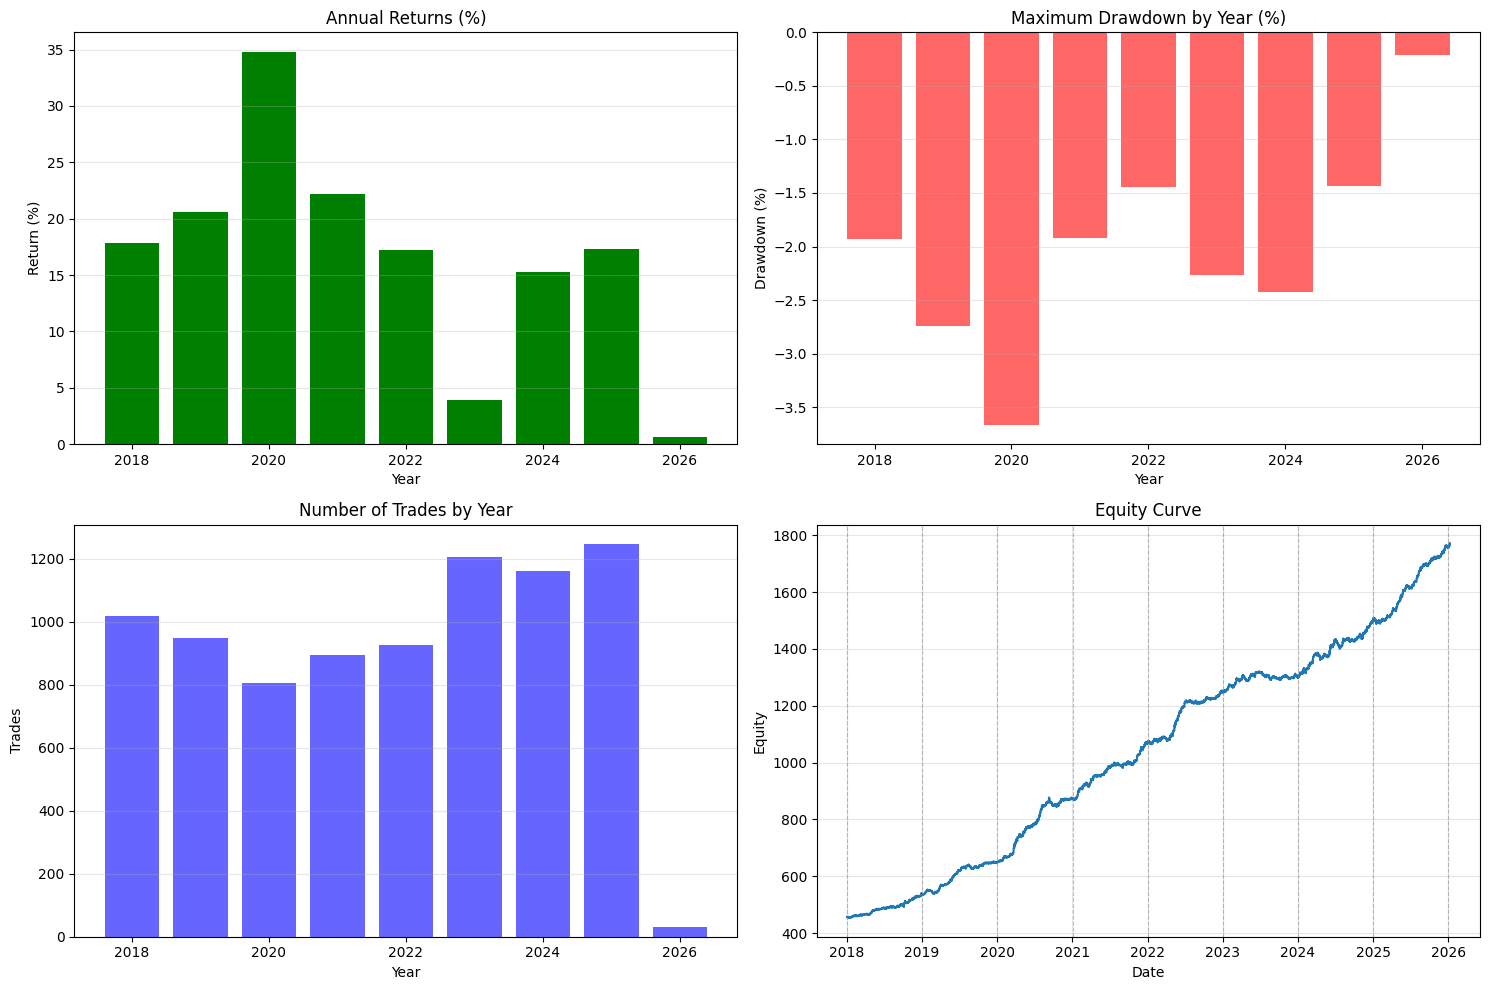

,year,Start Equity,End Equity,Total Return (%),Max Drawdown (%),Trades,Win Rate (%),Avg Win,Avg Loss,Sharpe Ratio
0,2018,456.000000,537.359462,17.841987,-1.927491,1019.0,60.058881,0.520143,-0.582231,0.187497
1,2019,537.359462,647.972276,20.584510,-2.743442,950.0,60.842105,0.645180,-0.705111,0.237500
2,2020,647.972276,873.415074,34.792044,-3.662657,805.0,62.732919,1.265979,-1.379588,0.262018
3,2021,873.415074,1067.528735,22.224675,-1.920842,896.0,61.941964,1.173932,-1.341404,0.221071
4,2022,1067.528735,1251.456197,17.229275,-1.442188,928.0,62.392241,1.171466,-1.416480,0.208935
5,2023,1251.456197,1301.035591,3.961736,-2.266627,1205.0,59.502075,0.753202,-1.005055,0.072199
6,2024,1301.035591,1499.932745,15.287603,-2.420056,1162.0,63.769363,1.131731,-1.519514,0.193632
7,2025,1499.932745,1759.421966,17.300057,-1.438307,1246.0,65.409310,0.977168,-1.245715,0.280464
8,2026,1759.421966,1771.114474,0.664565,-0.209037,30.0,76.666667,1.054229,-1.793536,0.459810


In [ ]:
df['year'] = df.index.year

# Group by year and calculate metrics
def calculate_year_metrics(group):
    # Equity metrics
    start_equity = group['equity_curve'].iloc[0]
    end_equity = group['equity_curve'].iloc[-1]
    year_return = (end_equity - start_equity) / start_equity * 100
    
    # Drawdown
    running_max = group['equity_curve'].cummax()
    drawdown = (group['equity_curve'] - running_max) / running_max * 100
    max_drawdown = drawdown.min()
    
    # Trade metrics
    trades = group[group['trade_pnl_total'] != 0]
    num_trades = len(trades)
    winning_trades = len(trades[trades['trade_pnl_total'] > 0])
    losing_trades = len(trades[trades['trade_pnl_total'] < 0])
    win_rate = (winning_trades / num_trades * 100) if num_trades > 0 else 0
    
    # Average win/loss
    avg_win = trades[trades['trade_pnl_total'] > 0]['trade_pnl_total'].mean() if winning_trades > 0 else 0
    avg_loss = trades[trades['trade_pnl_total'] < 0]['trade_pnl_total'].mean() if losing_trades > 0 else 0
    
    # Sharpe ratio
    daily_returns = group['equity_curve'].pct_change().dropna()
    sharpe = np.sqrt(252) * daily_returns.mean() / daily_returns.std() if len(daily_returns) > 1 and daily_returns.std() > 0 else 0
    
    return pd.Series({
        'Start Equity': start_equity,
        'End Equity': end_equity,
        'Total Return (%)': year_return,
        'Max Drawdown (%)': max_drawdown,
        'Trades': num_trades,
        'Win Rate (%)': win_rate,
        'Avg Win': avg_win,
        'Avg Loss': avg_loss,
        'Sharpe Ratio': sharpe
    })

# Apply to all years at once
yearly_df = df.groupby('year').apply(calculate_year_metrics).reset_index()

# Calculate overall CAGR
first_equity = df['equity_curve'].iloc[0]
last_equity = df['equity_curve'].iloc[-1]
years_total = (df.index[-1] - df.index[0]).days / 365.25
cagr = ((last_equity / first_equity) ** (1 / years_total) - 1) * 100

# Overall max drawdown
running_max_all = df['equity_curve'].cummax()
drawdown_all = (df['equity_curve'] - running_max_all) / running_max_all * 100
max_dd_all = drawdown_all.min()

print("=" * 80)
print("YEAR-ON-YEAR PERFORMANCE")
print("=" * 80)
print(yearly_df.to_string(index=False))
print("\n" + "=" * 80)
print("OVERALL METRICS")
print("=" * 80)
print(f"Starting Capital: ₹{first_equity:,.2f}")
print(f"Ending Capital: ₹{last_equity:,.2f}")
print(f"Total Return: {((last_equity/first_equity - 1) * 100):.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Max Drawdown: {max_dd_all:.2f}%")
print(f"Total Period: {years_total:.2f} years")
print("=" * 80)

# Same visualizations as before
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].bar(yearly_df['year'], yearly_df['Total Return (%)'], 
               color=['green' if x > 0 else 'red' for x in yearly_df['Total Return (%)']])
axes[0, 0].set_title('Annual Returns (%)')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Return (%)')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

axes[0, 1].bar(yearly_df['year'], yearly_df['Max Drawdown (%)'], color='red', alpha=0.6)
axes[0, 1].set_title('Maximum Drawdown by Year (%)')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Drawdown (%)')
axes[0, 1].grid(axis='y', alpha=0.3)

axes[1, 0].bar(yearly_df['year'], yearly_df['Trades'], color='blue', alpha=0.6)
axes[1, 0].set_title('Number of Trades by Year')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Trades')
axes[1, 0].grid(axis='y', alpha=0.3)

axes[1, 1].plot(df.index, df['equity_curve'], linewidth=1.5)
axes[1, 1].set_title('Equity Curve')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Equity')
axes[1, 1].grid(alpha=0.3)

for year in yearly_df['year'].unique():
    year_start = df[df['year'] == year].index[0]
    axes[1, 1].axvline(x=year_start, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)

plt.tight_layout()
plt.show()

yearly_df

In [ ]:
# # Then in the save section:
# results = {
#     'metadata': {
#         'filename': filename,
#         'timeframe': timeframe,
#         'timestamp': datetime.now().isoformat(),
#         'total_period_years': years_total,
#         'starting_capital': first_equity,
#         'ending_capital': last_equity,
#         'total_return_pct': ((last_equity/first_equity - 1) * 100),
#         'cagr_pct': cagr,
#         'max_drawdown_pct': max_dd_all
#     },
#     'yearly_performance': yearly_df.to_dict(orient='records')
# }

# key = f"{filename}_{timeframe}"

# json_filepath = '../research_consolidation/results_json/results_json.json'

# if os.path.exists(json_filepath):
#     with open(json_filepath, 'r') as f:
#         all_results = json.load(f)
# else:
#     all_results = {}

# all_results[key] = results

# with open(json_filepath, 'w') as f:
#     json.dump(all_results, f, indent=2)

# print(f"✓ Results saved with key: {key}")
# print(f"✓ Total runs in file: {len(all_results)}")

#### Sanity Check

In [ ]:
required_columns = ['open', 'high', 'low', 'close', 'volume', 'resistance', 'support','atr', 'rsi', 'sma_50', 'sma_200', 'sma_20','uptrend','ml_target', 'ml_target_short']
df = df[required_columns]
df.head()

,open,high,low,close,volume,resistance,support,atr,rsi,sma_50,sma_200,sma_20,uptrend,ml_target,ml_target_short
datetime,,,,,,,,,,,,,,,
2018-01-01 09:26:00+05:30,456.18,456.18,455.83,456.00,10750,456.94,456.18,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-01 09:27:00+05:30,456.08,456.18,455.73,456.15,12418,456.67,456.00,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-01 09:28:00+05:30,456.18,456.20,455.95,456.18,8792,456.47,456.00,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-01 09:29:00+05:30,456.18,456.20,455.95,456.05,14932,456.47,456.00,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-01 09:30:00+05:30,456.20,456.20,455.95,456.20,8054,456.47,456.00,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [ ]:
# required_columns = ['open', 'high', 'low', 'close', 'volume', 'resistance', 'support','atr', 'rsi', 'sma_50', 'sma_200', 'sma_20','uptrend','downtrend']
# df = df[required_columns]
# df.head()

In [ ]:
# df.to_csv(f"./raw_data_for_machine_learning/{filename}_{timeframe}.csv", index='datetime')

In [ ]:
df["ml_target"].notna().sum()

np.int64(5140)

In [ ]:
df["ml_target"].value_counts()

ml_target
-0.013018    5
-0.025318    4
-0.010270    3
 0.014338    3
-0.009333    3
            ..
-0.075911    1
 0.047922    1
 0.119384    1
-0.178725    1
 0.021545    1
Name: count, Length: 5065, dtype: int64

In [ ]:
df["ml_target_short"].notna().sum()

np.int64(3108)

In [ ]:
df["ml_target_short"].value_counts()

ml_target_short
 0.004902    2
 0.010010    2
 0.094222    2
 0.018151    2
 0.003878    2
            ..
 0.093071    1
-0.007810    1
 0.071918    1
 0.114863    1
 0.019290    1
Name: count, Length: 3096, dtype: int64

In [ ]:
df[df["ml_target_short"] == 1]["ml_target_short"]

Series([], Name: ml_target_short, dtype: float64)